# XGBoost Classifier - Implementation on Holiday Package Prediction Dataset

# About Dataset

## Context
"Trips & Travel.Com" company wants to enable and establish a viable business model to expand the customer base. One of the ways to expand the customer base is to introduce a new offering of packages. Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages. However, the marketing cost was quite high because customers were contacted at random without looking at the available information. The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being. However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.

## Goal
The goal of this notebook is to implement XGBoost Classifier on this dataset and find a model that could predict whether a given customer would buy or not buy a product based on the provided input.

Dataset source: https://www.kaggle.com/datasets/susant4learning/holiday-package-purchase-prediction

In [216]:
!pip install xgboost

In [217]:
import os
import torch
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
import pickle

In [218]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [219]:
print("sklearn version:",sklearn.__version__)

sklearn version: 1.2.2


In [220]:
%matplotlib inline
# warnings.filterwarnings(action='ignore')

In [221]:
# Impoorting the dataset
df = pd.read_csv("/kaggle/input/holiday-package-purchase-prediction/Travel.csv")

In [222]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [223]:
df.describe()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4888.000000,4637.000000,4888.000000,4843.000000,4862.000000,4748.000000,4888.000000,4888.000000,4888.000000,4822.000000,4655.000000
mean,202443.500000,0.188216,37.622265,1.654255,15.490835,2.905074,3.708445,3.581037,3.236521,0.290917,3.078151,0.620295,1.187267,23619.853491
std,1411.188388,0.390925,9.316387,0.916583,8.519643,0.724891,1.002509,0.798009,1.849019,0.454232,1.365792,0.485363,0.857861,5380.698361
min,200000.000000,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,201221.750000,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,202443.500000,0.000000,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,203665.250000,0.000000,44.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,204887.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

# Data Cleaning

* Handle Typographical Errors
* Handle Missing Values
* Handle Duplicates
* Check Datatypes

## Handling Typographical Errors

In [225]:
# Printing unique entries in all categorical columns
# Getting a list of all categorical columns
cat_cols = df.select_dtypes('object').columns.to_list()
# Printing unique entries to check for data entry errors
for column in cat_cols:
    print(df[column].value_counts(), end="\n\n")

TypeofContact
Self Enquiry       3444
Company Invited    1419
Name: count, dtype: int64

Occupation
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: count, dtype: int64

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

ProductPitched
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: count, dtype: int64

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

Designation
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: count, dtype: int64



* The gender column has a typo- 'Female' -> 'Fe male'.
* In MaritalStatus Column 'Unmarried' and 'Single' can be clubbed together

In [226]:
# Handling typo in 'Gender' column
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')

# Clubbing 'Unmarried' and 'Single' in MaritalStatus column
df['MaritalStatus'] = df['MaritalStatus'].replace('Unmarried', 'Single')

In [227]:
df['Gender'].value_counts()

Gender
Male      2916
Female    1972
Name: count, dtype: int64

In [228]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married     2340
Single      1598
Divorced     950
Name: count, dtype: int64

## Handling Missing Values

In [229]:
# Checking for null values
null = df.isnull().sum()
null = null[null != 0]
print(*null.index, sep=", ")
null

Age, TypeofContact, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting, MonthlyIncome


Age                         226
TypeofContact                25
DurationOfPitch             251
NumberOfFollowups            45
PreferredPropertyStar        26
NumberOfTrips               140
NumberOfChildrenVisiting     66
MonthlyIncome               233
dtype: int64

Age, TypeofContact, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting and MonthlyIncome columns have null values

### Checking for outliers

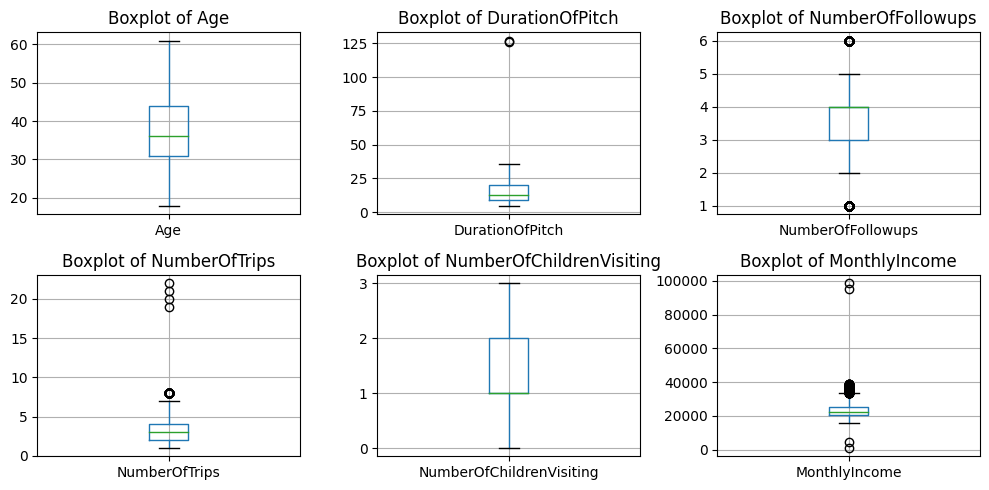

In [230]:
# Number of numeric columns with missing values
cols = ['Age', 'DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each numeric column
for i, column in enumerate(cols):
    df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [231]:
# Filling null values in columns without outliers with mean
cols_without_outliers = ['Age', 'NumberOfChildrenVisiting']

# Calculating Mean
mean = df[cols_without_outliers].mean()

# Filling
df[cols_without_outliers] = df[cols_without_outliers].fillna(value=mean)
df.isnull().sum()[cols_without_outliers]

Age                         0
NumberOfChildrenVisiting    0
dtype: int64

In [232]:
# Filling null values in columns with outliers with median
cols_with_outliers = ['DurationOfPitch', 'NumberOfFollowups', 'NumberOfTrips', 'MonthlyIncome']

# Calculating Median
median = df[cols_with_outliers].median() 

# Filling
df[cols_with_outliers] = df[cols_with_outliers].fillna(value=median)
df.isnull().sum()[cols_with_outliers]

DurationOfPitch      0
NumberOfFollowups    0
NumberOfTrips        0
MonthlyIncome        0
dtype: int64

In [233]:
# Fillinf Categorical Features with mode
cat_features = ['TypeofContact', 'PreferredPropertyStar']

# Calculating Mode
mode = df[cat_features].mode()
# Converting Mode from DataFrame to series
mode = mode.iloc[0]

# Fillinf
df[cat_features] = df[cat_features].fillna(value=mode)
df.isnull().sum()[cat_features]

TypeofContact            0
PreferredPropertyStar    0
dtype: int64

In [234]:
# Final Check for Null values
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

## Handling Duplicates

In [235]:
# Viewing duplicate rows
df[df.duplicated(keep=False)]

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome


## Handling Datatypes

In [236]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.000000,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.000000,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.000000,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.000000,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,37.622265,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [237]:
df.dtypes

CustomerID                    int64
ProdTaken                     int64
Age                         float64
TypeofContact                object
CityTier                      int64
DurationOfPitch             float64
Occupation                   object
Gender                       object
NumberOfPersonVisiting        int64
NumberOfFollowups           float64
ProductPitched               object
PreferredPropertyStar       float64
MaritalStatus                object
NumberOfTrips               float64
Passport                      int64
PitchSatisfactionScore        int64
OwnCar                        int64
NumberOfChildrenVisiting    float64
Designation                  object
MonthlyIncome               float64
dtype: object

Columns to convert:

* to int: Age, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, NumberOfChildrenVisiting

* to category: 'ProdTaken', 'TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched',                                                          'PreferredPropertyStar','MaritalStatus','Passport', 'OwnCar', 'Designation'

In [238]:
# Integer columns
int_columns = ['Age', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'NumberOfChildrenVisiting']
df[int_columns] = df[int_columns].astype('int')
df[int_columns].dtypes

Age                         int64
NumberOfFollowups           int64
PreferredPropertyStar       int64
NumberOfTrips               int64
NumberOfChildrenVisiting    int64
dtype: object

In [239]:
# Category Columns
cat_columns = ['ProdTaken', 'TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'PreferredPropertyStar',
               'MaritalStatus','Passport', 'OwnCar', 'Designation']
df[cat_columns] = df[cat_columns].astype('category')
df[cat_columns].dtypes

ProdTaken                category
TypeofContact            category
CityTier                 category
Occupation               category
Gender                   category
ProductPitched           category
PreferredPropertyStar    category
MaritalStatus            category
Passport                 category
OwnCar                   category
Designation              category
dtype: object

In [240]:
# Final Check for dtypes
df.dtypes

CustomerID                     int64
ProdTaken                   category
Age                            int64
TypeofContact               category
CityTier                    category
DurationOfPitch              float64
Occupation                  category
Gender                      category
NumberOfPersonVisiting         int64
NumberOfFollowups              int64
ProductPitched              category
PreferredPropertyStar       category
MaritalStatus               category
NumberOfTrips                  int64
Passport                    category
PitchSatisfactionScore         int64
OwnCar                      category
NumberOfChildrenVisiting       int64
Designation                 category
MonthlyIncome                float64
dtype: object

# Feature Engineering

In [241]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41,Self Enquiry,3,6.0,Salaried,Female,3,3,Deluxe,3,Single,1,1,2,1,0,Manager,20993.0
1,200001,0,49,Company Invited,1,14.0,Salaried,Male,3,4,Deluxe,4,Divorced,2,0,3,1,2,Manager,20130.0
2,200002,1,37,Self Enquiry,1,8.0,Free Lancer,Male,3,4,Basic,3,Single,7,1,3,0,0,Executive,17090.0
3,200003,0,33,Company Invited,1,9.0,Salaried,Female,2,3,Basic,3,Divorced,2,1,5,1,1,Executive,17909.0
4,200004,0,37,Self Enquiry,1,8.0,Small Business,Male,2,3,Basic,4,Divorced,1,0,5,1,0,Executive,18468.0


In [242]:
# Dropping CustomerID column
df = df.drop(columns=['CustomerID'])
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,41,Self Enquiry,3,6.0,Salaried,Female,3,3,Deluxe,3,Single,1,1,2,1,0,Manager,20993.0
1,0,49,Company Invited,1,14.0,Salaried,Male,3,4,Deluxe,4,Divorced,2,0,3,1,2,Manager,20130.0
2,1,37,Self Enquiry,1,8.0,Free Lancer,Male,3,4,Basic,3,Single,7,1,3,0,0,Executive,17090.0
3,0,33,Company Invited,1,9.0,Salaried,Female,2,3,Basic,3,Divorced,2,1,5,1,1,Executive,17909.0
4,0,37,Self Enquiry,1,8.0,Small Business,Male,2,3,Basic,4,Divorced,1,0,5,1,0,Executive,18468.0


# Correlations

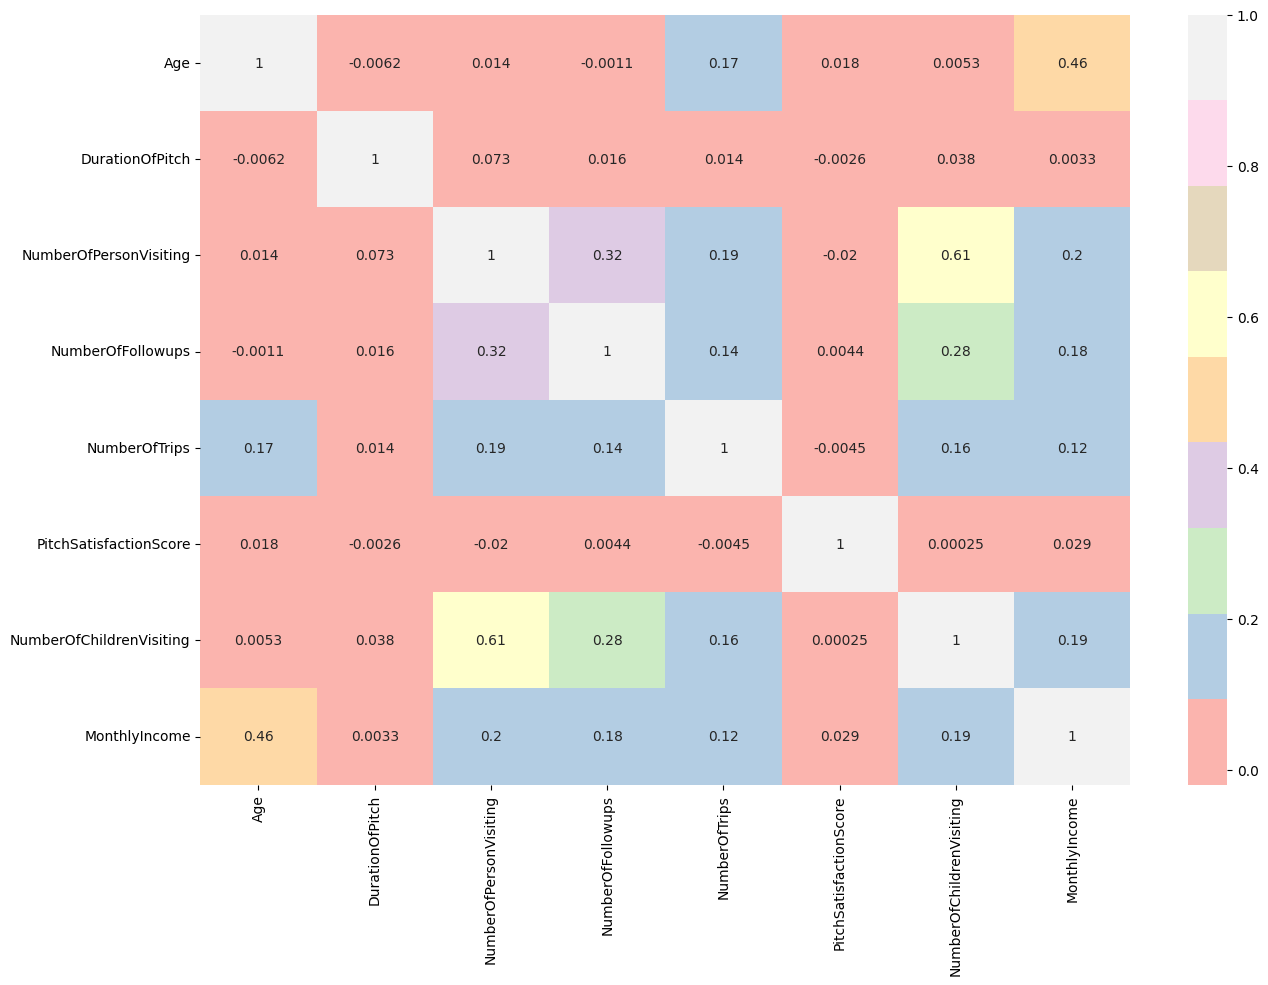

In [243]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(data=corr, annot=True, cmap='Pastel1');

# Train Test Split

In [244]:
# Independent Features
X = df.drop(columns='ProdTaken', axis=1)
# Dependent Features
y = df['ProdTaken']

In [245]:
X.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,41,Self Enquiry,3,6.0,Salaried,Female,3,3,Deluxe,3,Single,1,1,2,1,0,Manager,20993.0
1,49,Company Invited,1,14.0,Salaried,Male,3,4,Deluxe,4,Divorced,2,0,3,1,2,Manager,20130.0
2,37,Self Enquiry,1,8.0,Free Lancer,Male,3,4,Basic,3,Single,7,1,3,0,0,Executive,17090.0
3,33,Company Invited,1,9.0,Salaried,Female,2,3,Basic,3,Divorced,2,1,5,1,1,Executive,17909.0
4,37,Self Enquiry,1,8.0,Small Business,Male,2,3,Basic,4,Divorced,1,0,5,1,0,Executive,18468.0


In [246]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: ProdTaken, dtype: category
Categories (2, int64): [0, 1]

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((3910, 18), (978, 18))

# Column Transformations - Encoding Categorical Features

In [248]:
# List of categorical columns
cat_cols = X_train.select_dtypes(include='category').columns.to_list()
cat_cols

['TypeofContact',
 'CityTier',
 'Occupation',
 'Gender',
 'ProductPitched',
 'PreferredPropertyStar',
 'MaritalStatus',
 'Passport',
 'OwnCar',
 'Designation']

In [249]:
for column in cat_cols:
    print(column)
    print(df[column].value_counts(), end="\n\n")

TypeofContact
TypeofContact
Self Enquiry       3469
Company Invited    1419
Name: count, dtype: int64

CityTier
CityTier
1    3190
3    1500
2     198
Name: count, dtype: int64

Occupation
Occupation
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: count, dtype: int64

Gender
Gender
Male      2916
Female    1972
Name: count, dtype: int64

ProductPitched
ProductPitched
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: count, dtype: int64

PreferredPropertyStar
PreferredPropertyStar
3    3019
5     956
4     913
Name: count, dtype: int64

MaritalStatus
MaritalStatus
Married     2340
Single      1598
Divorced     950
Name: count, dtype: int64

Passport
Passport
0    3466
1    1422
Name: count, dtype: int64

OwnCar
OwnCar
1    3032
0    1856
Name: count, dtype: int64

Designation
Designation
Executive         1842
Manager           1732
Senior Manager     742
AVP                342

In [250]:
# Initializing the transformer
transformer = ColumnTransformer(transformers=[('categorical', OneHotEncoder(), cat_cols)],
                               remainder='passthrough')

In [251]:
# Fitting and Transforming X_train
X_train = transformer.fit_transform(X_train)

In [252]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,36.0,7.0,2.0,5.0,3.0,4.0,1.0,21537.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,42.0,21.0,3.0,4.0,6.0,4.0,2.0,21129.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,50.0,7.0,3.0,4.0,4.0,4.0,1.0,22258.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,38.0,7.0,3.0,5.0,3.0,5.0,1.0,24671.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,44.0,35.0,4.0,2.0,6.0,3.0,3.0,23417.0


In [253]:
# Transforming X_test
X_test = transformer.transform(X_test)

In [254]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,32.0,13.0,2.0,5.0,1.0,2.0,1.0,19668.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,46.0,11.0,3.0,4.0,1.0,5.0,1.0,20021.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,37.0,22.0,3.0,4.0,5.0,5.0,0.0,21334.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,43.0,36.0,3.0,6.0,6.0,3.0,2.0,22950.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,25.0,7.0,4.0,4.0,3.0,4.0,3.0,21880.0


# Sample XGBClassifier Model

In [270]:
# Initializing
sample_model = XGBClassifier(n_jobs=-1, random_state=42) # Using random_state for reproducibility

In [271]:
# Fitting to X_train, y_train
sample_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [272]:
# Sample Prediction
sample_y_pred = sample_model.predict(X_test)

## Sample Model Scores

In [273]:
sample_accuracy = accuracy_score(y_test, sample_y_pred)

In [274]:
print("Accuracy of sample model:", sample_accuracy)

Accuracy of sample model: 0.9355828220858896


# Hyperparameter Tuning

In [275]:
### Initializing Hyperparameters
param_grid = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8, 12, 20, 30],
              "n_estimators": [100, 200, 300],
              "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

In [276]:
# Initializing Tuner
grid = GridSearchCV(estimator = XGBClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5)

In [277]:
# Finding best model
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.8, 1, 0.3, 0.4],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 8, 12, 20, 30],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [278]:
model = grid.best_estimator_
params = grid.best_params_
params # Best Parameters

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 300}

## Model Scores and ROC Curve

In [279]:
y_pred = model.predict(X_test)

In [280]:
accuracy = accuracy_score(y_test, y_pred)

In [281]:
print("Sample Model Accuracy:", sample_accuracy, end="\n\n")
print("Model Accuracy after hyperparameter tuning:", accuracy)

Sample Model Accuracy: 0.9355828220858896

Model Accuracy after hyperparameter tuning: 0.9478527607361963


In [282]:
print(f'The model score has changed from {sample_accuracy:.2f} to {accuracy:.2f} after hyperparameter tuning.')

The model score has changed from 0.94 to 0.95 after hyperparameter tuning.


* RandomForestClassifier had earlier given a better accuracy of 0.948, in our implemantation of that classifier - [Link to notebook](https://www.kaggle.com/code/sharooqfarzeenak/random-forest-classifier-holiday-package-dataset)

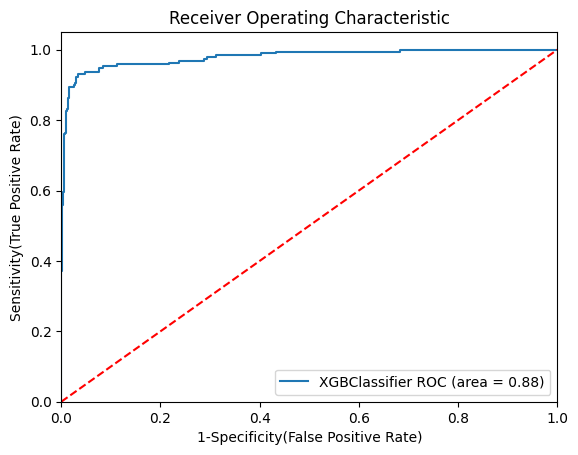

In [283]:
# Plotting the ROC Curve

# Computing ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
# Compute False postive rate, and True positive rate
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])


plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("XGBClassifier", roc_auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [284]:
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [285]:
print("Model Scores\n")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC Score:", roc_auc)

Model Scores

Accuracy: 0.9478527607361963
F1 Score: 0.8513119533527697
Precision: 0.9605263157894737
Recall: 0.7643979057591623
ROC-AUC Score: 0.8783870087880945


# Saving the model

In [286]:
# Finding out best model
best_model = model if accuracy > sample_accuracy else sample_model
best_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [287]:
# Directory where model has to be stored
directory = '/kaggle/working/'
# Path to pickle the model
path = os.path.join(os.getcwd(), directory, 'xgboostclassifier.json')

best_model.save_model(path)

In [288]:
print("Model has been pickled at", path)

Model has been pickled at /kaggle/working/xgboostclassifier.json
